# [Deep Learning for Vision Systems](https://www.manning.com/books/deep-learning-for-vision-systems?a_aid=compvisionbookcom&a_bid=90abff15) Book


## Chapter 6 Project: Transfer learning exercise

---
### 1. Import the libraries that we need


In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.applications import mobilenet
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


### 2. Data preparation

In [2]:
train_path  = 'data/train'
valid_path  = 'data/valid'
test_path  = 'data/test'
N=50 # epoch number

In [3]:
train_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    train_path, target_size=(1280,960), batch_size=20)
valid_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    valid_path, target_size=(1280,960), batch_size=20)
test_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    test_path, target_size=(1280,960), batch_size=20)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 416 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


### 3. Download VGGNet and create our new network



In [4]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (1280,960,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1280, 960, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1280, 960, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1280, 960, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 640, 480, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 640, 480, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 640, 480, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 320, 240, 128)     0     

In [5]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1280, 960, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1280, 960, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1280, 960, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 640, 480, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 640, 480, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 640, 480, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 320, 240, 128)     0     

In [6]:
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

# use “get_layer” method to save the last layer of the network
# save the output of the last layer to be the input of the next layer
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

# add 2 FC layers, each has 4096 units and relu activation 
x = Dense(64, activation='relu', name='FC_2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# add our new softmax layer with 3 hidden units
x = Dense(2, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1280, 960, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1280, 960, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1280, 960, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 640, 480, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 640, 480, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 640, 480, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 320, 240, 128)     0   

In [7]:
new_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy']) # lr = 0.00001

In [8]:
# to save the model perform best at the epoch
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [9]:
H=new_model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=2, epochs=N, verbose=2,callbacks=callbacks)

Epoch 1/50
 - 35s - loss: 0.9921 - accuracy: 0.5625 - val_loss: 3.5519 - val_accuracy: 0.5500

Epoch 00001: val_loss improved from inf to 3.55191, saving model to my_best_model.hdf5
Epoch 2/50
 - 10s - loss: 0.7120 - accuracy: 0.7125 - val_loss: 3.4673 - val_accuracy: 0.5250

Epoch 00002: val_loss improved from 3.55191 to 3.46732, saving model to my_best_model.hdf5
Epoch 3/50
 - 9s - loss: 0.4612 - accuracy: 0.7750 - val_loss: 1.0478 - val_accuracy: 0.6500

Epoch 00003: val_loss improved from 3.46732 to 1.04782, saving model to my_best_model.hdf5
Epoch 4/50
 - 8s - loss: 0.3569 - accuracy: 0.8500 - val_loss: 0.5399 - val_accuracy: 0.7750

Epoch 00004: val_loss improved from 1.04782 to 0.53994, saving model to my_best_model.hdf5
Epoch 5/50
 - 14s - loss: 0.3226 - accuracy: 0.8816 - val_loss: 0.5638 - val_accuracy: 0.8500

Epoch 00005: val_loss did not improve from 0.53994
Epoch 6/50
 - 9s - loss: 0.4627 - accuracy: 0.8500 - val_loss: 0.6251 - val_accuracy: 0.8250

Epoch 00006: val_loss 

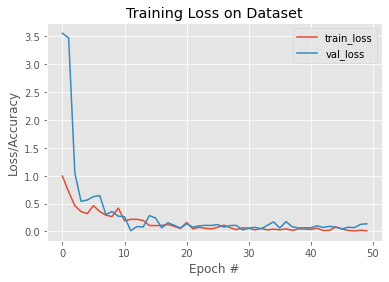

In [10]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig("loss.png")

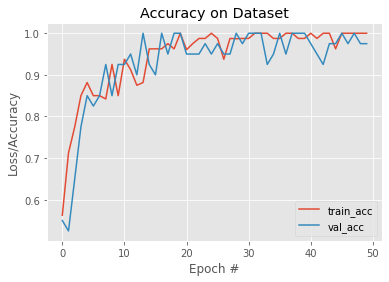

In [11]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("accu.png")

### 4. Reload the model and Evaluate a stored model

In [13]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [14]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from keras.models import Sequential, load_model

test_files, test_targets = load_dataset('data/test')

In [15]:
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(1280,960,3))
    # convert PIL.Image.Image type to 3D tensor with shape (1280,960, 1280,960, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 1280,960, 1280,960, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 118/118 [00:01<00:00, 66.47it/s]


In [29]:
new_model = load_model('./my_best_model.hdf5')
# new_model = load_model('./result/result_721/my_best_model.hdf5')

# Check its architecture
# new_model.summary()

In [30]:
# Evaluate the restored model
#loss, acc = new_model.evaluate(test_tensors, test_targets, verbose=2, batch_size=10)
#print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

In [31]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets, batch_size=5)))

118/118 [==============================] - 9s 74ms/step

Testing loss: 0.1329
Testing accuracy: 0.9661


#### Confusion Matrix

In [32]:
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from pathlib import Path
import cv2
from keras.models import Sequential, load_model
import shutil
import matplotlib.pyplot as plt 
import seaborn as sns

In [33]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(1280,960,3))
    # convert PIL.Image.Image type to 3D tensor with shape (1280,960, 1280,960, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 1280,960, 1280,960, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [41]:
test_dir = 'data/test'
tp=0
tn=0
fp=0
fn=0
t_path = Path(test_dir)
new_model = load_model('my_best_model.hdf5')
classlist = [str(p.absolute()) for p in list(t_path.glob('*'))]
# print(os.path.basename(folderpath))


In [42]:
for i,clas in enumerate(classlist):
    testlist = os.listdir(clas)
#     print(testlist)
#     print(i)
    for ea in testlist:
        
        img_name = path_to_tensor(clas+'/'+ea)
        name_str = os.path.basename(str(ea))
    #     im = cv2.imread(img)
    #     x = image.img_to_array(im)
    #     x = np.expand_dims(im, axis=0)
        result_pre = new_model.predict(img_name)
    #     print(result_pre.size)
#         print(result_pre)
    #     if result_pre[0][1]>0.75:
        if result_pre[0][1]>result_pre[0][0] and i == 0:
            tp+=1
        if result_pre[0][1]<result_pre[0][0] and i == 0:
            fn+=1
        if result_pre[0][1]>result_pre[0][0] and i == 1:
            fp+=1
        if result_pre[0][1]<result_pre[0][0] and i == 1:
            tn+=1

In [43]:
cm = [[tp,   fn],
       [  fp,  tn]]
print(cm)

[[52, 7], [10, 49]]


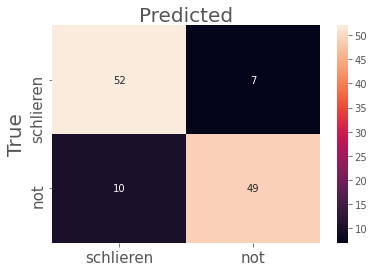

In [44]:
%matplotlib inline 
# above is necessary to visualize the graph in jupyter notebook
# Plot confusion matrix in a beautiful manner

fig = plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('top') 
ax.xaxis.set_ticklabels(['schlieren', 'not'], fontsize = 15)
# ax.xaxis.tick_top()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['schlieren', 'not'], fontsize = 15)

plt.show()
fig.savefig('matrix.png')

### 5. Predict individual image and put them into separate folder

In [45]:
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from pathlib import Path
import cv2
from keras.models import Sequential, load_model
import shutil

In [46]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(1280,960,3))
    # convert PIL.Image.Image type to 3D tensor with shape (1280,960, 1280,960, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 1280,960, 1280,960, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [47]:
#new_model = load_model('./my_best_model.hdf5')
new_model = load_model('/home/hhuan006/Desktop/schlieren project/result/result_721/my_best_model.hdf5')

# Check its architecture
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1280, 960, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1280, 960, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1280, 960, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 640, 480, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 640, 480, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 640, 480, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 320, 240, 128)     0   

In [ ]:
# dir_predict = '/home/hhuan006/Bermuda_FoSi2_CTD_camera_April_2019/OFPCTD5/'
dir_predict = '/home/hhuan006/Bermuda_FoSi2_CTD_camera_April_2019/OFPCTD3/'
dir_save_pred = '/home/hhuan006/sch_pred_results/cast-3/'
if not os.path.exists(dir_save_pred):
    os.makedirs(dir_save_pred)
    
folderpath = Path(dir_predict)
dirlist = [str(p.absolute()) for p in list(folderpath.glob('*'))]
# print(os.path.basename(folderpath))
for each in dirlist:
    img_name = path_to_tensor(each)
    name_str = os.path.basename(str(each))
#     im = cv2.imread(img)
#     x = image.img_to_array(im)
#     x = np.expand_dims(im, axis=0)
    result_pre = new_model.predict(img_name)
#     print(result_pre.size)
    print(result_pre)
#     if result_pre[0][1]>0.75:
    if result_pre[0][1]>result_pre[0][0]:
        shutil.copy2(str(each), dir_save_pred+name_str[0:-5]+'_'+str(result_pre[0][1])+'.bmp') # complete target filename given
